# Capstone Project: IMDB User Reviews Rating predictor
## Hung Pham

## Part 3: Modelling

Follow up with part 2, we cleaned our text data, ready for modeling.  
In this part, we will explore several method and find  the best model to help us predict the review rating.

### 3.1. Preparing

#### 3.1.1. Importing libraries

Usual step, we will need to import all the libraries needed.

In [16]:
#importing basic libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [17]:
import time #import time library as we will need to use it to check the runtime of our model
from datetime import timedelta
from tempfile import mkdtemp

In [18]:
#Importing libraries to split data and convert text to numerical data
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [19]:
#Importing libraries for ML
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [20]:
!pip install mord 
#Importing Mord library
from mord import LogisticIT, LogisticAT, LAD, OrdinalRidge

In [21]:
#Imporitng scoring library for model evaluation
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [22]:
#Importing neural network libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import plot_model

In [23]:
#Importing joblib to store our model to joblib file to use later
import joblib

#### 3.1.2. Loading data

As I mainly used Google Colab for this part instead of Jupyterlab, I uploaded the cleaned file from part 2 onto my personal AWS S3 bucket. As Pandas support loading dataframe directly from S3.  
We can check our dataframe here:

In [24]:
df = pd.read_csv('https://hungpham-brainstation.s3.us-east-2.amazonaws.com/review_cleaned_final.csv')
df

,Review_body,Review_rating
0,plz dont watch movi base rate cant even get ha...,1
1,not repeat not see movi glad download movi ins...,1
2,wish could sue salman khan bring back time mon...,1
3,imagin posterboy camera shi anoth word rememb ...,1
4,start write end movi end no resolut,1
...,...,...
24875,movi held edg seat incred watch histori unfold...,10
24876,film must see one friend said seen real cinema...,10
24877,incred epic soundtrack charact plot cast direc...,10
24878,cameron alien complet differ beast ridey scott...,10


For sanity check, let's check the distribution of the classes (`Review_rating`) to make sure we have the right data:

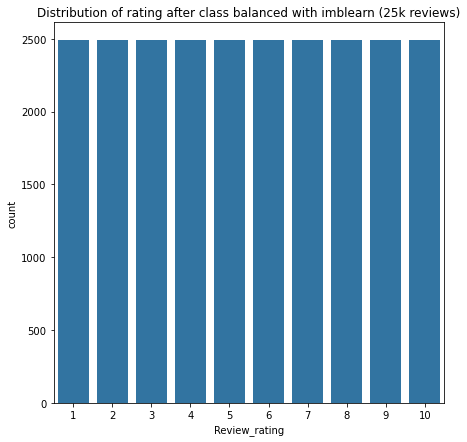

In [25]:
plt.figure(figsize= (7,7))
sns.countplot(df['Review_rating'], color = 'tab:blue')
plt.title('Distribution of rating after class balanced with imblearn (25k reviews)', fontsize = 12)
plt.show()

#### 3.1.3. Train-test split

Everything seem correctly, we can now define our feature and target now. As we want to predict the rating score sorely from the review text, `Review_body` is our only feature here. And the target is of course `Review_rating`

In [26]:
#Define feature, target and split them out to trainset 
X = df[['Review_body']]
y = df['Review_rating']
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size = 0.2, #Set train/test ratio as 80/20
                                                    stratify = y,#stratify to make sure train and test set has the same ratio of classes
                                                    random_state = 42) 

In [27]:
X_train

,Review_body
3189,start review would like say not seen origin wi...
3201,movi lot like junor high lot stupid fart joke ...
4622,good exampl hollywood spend lot money star dir...
17209,shure good movi product great visual audio cut...
8429,whiplash surfac tens complex studi artist stru...
...,...
22616,begin comment one beauti haunt tragic yet slig...
20243,pro score utterli magic quintessenti italian f...
13068,no fanboy not hater either watch mcu film love...
4834,time waster would worth watch script contain e...


#### 3.1.4. Vectorizing

As we see in the EDA, the two most frequent words by a large margin in the review text are movie and film, which is neutral and doesn't contribute much to the sentiment of the review. So, if we just count them normally, they will effect the accuracy of the model.  

To tackle this problem I decided to use TfidfVectorizer here to vectorize the corpus instead of CountVectorizer. Tfidf tend to consider overall document weight of a word and penalize the most frequents.  

One more benefit of Tfidf is that it normalizes the data for us as well so we dont have to rerun this step.

In [28]:
# #Instantiate the vectorizer
# tfidf_vec =  CountVectorizer(max_df=0.8, #using max_df to ignore any
#                              min_df=10)
# #Fit
# tfidf_vec = tfidf_vec.fit(X_train)

# #Transform both train and test set with the fitted model
# X_train_tran = tfidf_vec.transform(X_train)
# X_test_tran = tfidf_vec.transform(X_test)

# # After getting the data, we can build back the dataframe:
# X_train_tran_df = pd.DataFrame(X_train_tran.toarray(), columns = tfidf_vec.get_feature_names())
# X_test_tran_df = pd.DataFrame(X_test_tran.toarray(), columns = tfidf_vec.get_feature_names())

In [29]:
from sklearn.compose import ColumnTransformer
#Instantiate the ColumnTransformer module:
col_transform = [('tfidf_vec', TfidfVectorizer(stop_words= 'english',
                                               max_df=0.8,
                                               min_df=10),'Review_body')] #Select tranform method, hyperparameter and column to perform


#Instantiate the column transformer
col_trans = ColumnTransformer(col_transform)

#Fit
col_trans.fit(X_train) #fit the transformer with our train data

#Transform
X_train_tran = col_trans.transform(X_train) #Note that we use the same fit model to transform both train and test set
X_test_tran = col_trans.transform(X_test)

# After getting the data, we can build back the dataframe:
X_train_tran_df = pd.DataFrame(X_train_tran.toarray(), columns = col_trans.get_feature_names())
X_test_tran_df = pd.DataFrame(X_test_tran.toarray(), columns = col_trans.get_feature_names())

In [30]:
#save col_trans model for use later in the demo
#joblib.dump(col_trans, '/content/drive/MyDrive/Colab Notebooks/result/col_tran.joblib')

Let's check our train dataframe:

In [31]:
X_train_tran_df

,tfidf_vec__aaron,tfidf_vec__ab,tfidf_vec__abandon,tfidf_vec__abba,tfidf_vec__abc,tfidf_vec__abduct,tfidf_vec__abhorr,tfidf_vec__abid,tfidf_vec__abil,tfidf_vec__abject,...,tfidf_vec__zero,tfidf_vec__zillion,tfidf_vec__zimmer,tfidf_vec__zip,tfidf_vec__zoe,tfidf_vec__zombi,tfidf_vec__zone,tfidf_vec__zoo,tfidf_vec__zoom,tfidf_vec__zucker
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19902,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3.2. Outlining the modeling process outline and define evaluation metrics

Reviewing the problem at hand, we can easily spot that it is a multi classes classification problem.  
But if we take a deeper look, it is actually a little bit different. Most of the classification models we have are designed to deal with nominal classes, which mean they are separated and independent with each others, e.g. to classify a picture of a cat or a dog.  
However, our classes here are ordinal classes, which mean they have a ordered relationship with each other (a movie rated 10 is better than 9 and so on). If we just try a normal classification model, we will miss out the information from this order.  

There are many advance techniques to deal with this problem, but due to the time constrain and scope of this project, I will use a library built especially for ordinal classification: **MORD**, we will use to models in this libraries:  
- LogisticAT, Classifier that implements the ordinal logistic model (All-Threshold variant)
- LogisticIT, (Immediate-Threshold variant)

But we dont want to miss out on other methods, maybe out there is a simpler model is that just right for our problem. 
So, follow my favorite Machine Learning quote: "Experiment, experiment, experiment. And if in doubt, write some code to experiment", my process for modeling would be:  
- Run a baseline model for LogisticAT and LogisticIT from mord, Logistic Regression, Linear Regression, SVM, Naive Bayer from sklearn
- Choose the model with best performance and run a pipeline to find the best possible hyperparameters. We can run a gridsearch for all models but due to the limit of personal computer, we will have to accept a sub optimal approach.
- Build a regression neural network and see if it can improve performance.

To evaluate a multi classes, we want to use a confusion matrix. The tighter the predicted data across the diagonal, the better performance. 

Furthermore, we would want to check accuracy if the predicted scores are close enough. For that, we can define a function to tell us the exact and adjacent accuracy: 

In [32]:
def three_scores(y_hat):
    '''
    Function take 1 input: predicted values from model (y_hat)
    
    Return 
    acc_0: precise accuracy, only count exact match.
    acc_1: adjacent accuracy, count if the predicted value is within 1 range from true value.
    acc_2: 2-steps adjacent accuracy, count if the predicted value is within 2 range from true value.
    Values calcualted as fraction.
    '''
    count_0 = np.where(y_hat - y_test ==0, 1,0) #Count how many exact match
    count_1 = np.where(abs(y_hat - y_test)<=1,1,0) #Count how many matched within range of 1
    count_2 = np.where(abs(y_hat - y_test)<=2,1,0) #Count how many matched within range of 2
    acc_0 = count_0.sum()/len(count_0) #Calculate the accuracy
    acc_1 = count_1.sum()/len(count_1)
    acc_2 = count_2.sum()/len(count_2)

    return acc_0, acc_1, acc_2

Then we can go further and make a new function to plot out the distribution of predicted values, as well as confusion matrix:

In [33]:
def confu_matrix(y_hat):
    '''
    Function take 1 input: predicted values from model (y_hat)
    Plot confusion matrix 
    Print out accurracy for each error ranges.
    '''
    
    
#     #plot the distribution of y_hat 
#     plt.figure(figsize=(7,7))
#     ax = sns.countplot(y_hat, color = 'tab:blue')
#     plt.show()
    
    #Plot confusion matrix
    cf_matrix = confusion_matrix(y_test, y_hat)
    cf_matrix = pd.DataFrame(cf_matrix, columns = range(1,11), index = range(1,11))
    plt.figure(figsize=(10,8)) #Set figure size
    sns.heatmap(cf_matrix, #choose data for the heatmap
              cmap = 'YlGnBu', #set color map
              annot = True, #showing value inside the square
              fmt = '.0f', #format value to show whole number with no decimal point
              annot_kws={"fontsize":15}) #set font size for our values
    plt.title('Confusion Matrix',size = 20)
    plt.xlabel("Predicted Label", size = 15)
    plt.ylabel("True Label", size = 15) #naming our plot
    plt.show()

    #print out accuracies values using three_scores function
    acc_0, acc_1, acc_2 = three_scores(y_hat)
        
    print(f'Precise accuracy: {acc_0}')
    print(f'Adjacent accuracy: {acc_1}')
    print(f'2-steps adjacent accuracy: {acc_2}')

### 3.3. Modeling with shallow learning

We can first set up an empty list to store the accuracies.  
After that, the process is straight forward: Run the model with default parameters, check the accuracies and decide what model we will go further to find it optimal hyperparameters.

In [34]:
acc_0_summary = []
acc_1_summary = []
acc_2_summary = []

#### 3.3.1. MORD - LogisticIT

First, run the baseline model for LogisticIT. Lucly for us, the API of **MORD** is exactly the same with **sklearn**.

In [35]:
#Instantiate model
my_mord_IT = LogisticIT()
#Fit
my_mord_IT = my_mord_IT.fit(X_train_tran_df, y_train)
#Predict
y_hat_mord_IT = my_mord_IT.predict(X_test_tran_df)

Let's check it's accuracies:

In [36]:
acc_0,acc_1, acc_2 = three_scores(y_hat_mord_IT)
acc_0_summary.append(acc_0) #append the accuracies to summary list
acc_1_summary.append(acc_1)
acc_2_summary.append(acc_2)
print(f'Precise accuracy: {acc_0}')
print(f'Adjacent accuracy: {acc_1}')
print(f'2-steps adjacent accuracy: {acc_2}')

Precise accuracy: 0.244975884244373
Adjacent accuracy: 0.5627009646302251
2-steps adjacent accuracy: 0.780144694533762


#### 3.3.2. MORD - LogisticAT

Baseline model:

In [37]:
#Instantiate model
my_mord_AT = LogisticAT()
#Fit
my_mord_AT = my_mord_AT.fit(X_train_tran_df, y_train)
#Predict
y_hat_mord_AT = my_mord_AT.predict(X_test_tran_df)

In [38]:
acc_0,acc_1, acc_2 = three_scores(y_hat_mord_AT)
acc_0_summary.append(acc_0)
acc_1_summary.append(acc_1)
acc_2_summary.append(acc_2)

print(f'Precise accuracy: {acc_0}')
print(f'Adjacent accuracy: {acc_1}')
print(f'2-steps adjacent accuracy: {acc_2}')

Precise accuracy: 0.23311897106109325
Adjacent accuracy: 0.5964630225080386
2-steps adjacent accuracy: 0.8181270096463023


#### 3.3.3. Linear Regression

One other simple approach for ordinal classification is to just run the model as a linear regression, and then convert the predicted values from continuous to discreet. 
Let's check it out:

In [39]:
#Instantiate the model
my_linear = LinearRegression()
#Fit model
my_linear = my_linear.fit(X_train_tran_df, y_train)

#Predict
y_hat_linear = my_linear.predict(X_test_tran_df)

We need an extra step to convert the predicted values back to our classes, and then check it's accuracies

In [40]:
# Squeeze y_hat back to 1 dimension
y_hat_linear = y_hat_linear.round().squeeze()
# Convert extreme value into their respective min,max
y_hat_linear = np.where(y_hat_linear >10,10,y_hat_linear)
y_hat_linear = np.where(y_hat_linear <1,1,y_hat_linear)
acc_0,acc_1, acc_2 = three_scores(y_hat_linear)
acc_0_summary.append(acc_0)
acc_1_summary.append(acc_1)
acc_2_summary.append(acc_2)

print(f'Precise accuracy: {acc_0}')
print(f'Adjacent accuracy: {acc_1}')
print(f'2-steps adjacent accuracy: {acc_2}')

Precise accuracy: 0.19071543408360128
Adjacent accuracy: 0.4991961414790997
2-steps adjacent accuracy: 0.7104099678456591


#### 3.3.2. Logistic Regression

Baseline model:

In [41]:
#Instantiate the model
my_log = LogisticRegression(multi_class='multinomial', 
                               solver='newton-cg')
#Fit model
my_log = my_log.fit(X_train_tran_df, y_train)

#Predict
y_hat_log = my_log.predict(X_test_tran_df)

In [53]:
my_log.coef_
my_log_df = pd.DataFrame(data = my_log.coef_)

In [54]:
my_log_df.shape

(10, 9174)

In [50]:
LogReg = my_log
LogReg.coef_ #Get attribute for coefficient from our model
Log_coef_df = pd.DataFrame(data = LogReg.coef_, #Build a dataframe for coef
                           columns = X_train_tran_df.columns).T.reset_index() #Getting respective columns' name from our original df, then transpose and reset index

In [51]:
Log_coef_df

,index,0,1,2,3,4,5,6,7,8,9
0,tfidf_vec__aaron,0.110312,-0.124860,0.229483,-0.186600,0.090109,-0.033521,0.127513,-0.053680,-0.220420,0.061664
1,tfidf_vec__ab,0.320729,0.099647,0.146673,0.055746,-0.083542,-0.152781,-0.073712,-0.134887,-0.105743,-0.072130
2,tfidf_vec__abandon,0.098150,0.242603,0.141020,-0.122646,-0.174987,-0.348508,0.040810,-0.100207,0.638309,-0.414545
3,tfidf_vec__abba,-0.102712,-0.117954,-0.129925,0.277318,0.186603,-0.111772,0.035210,-0.004859,0.027518,-0.059427
4,tfidf_vec__abc,-0.140451,-0.074486,-0.159675,0.309196,-0.085895,-0.005991,0.057276,0.246238,-0.052014,-0.094197
...,...,...,...,...,...,...,...,...,...,...,...
9169,tfidf_vec__zombi,0.420313,0.129797,-0.349119,0.480349,-0.100714,-0.122459,-0.117914,0.030075,-0.505579,0.135250
9170,tfidf_vec__zone,-0.005763,0.011947,-0.119600,-0.176714,0.318154,-0.024679,-0.008265,-0.177647,0.161626,0.020941
9171,tfidf_vec__zoo,-0.078507,-0.254840,0.119813,0.374831,-0.117984,-0.011944,-0.057091,0.130350,-0.058783,-0.045845
9172,tfidf_vec__zoom,-0.031100,0.117096,-0.017935,0.090837,-0.015470,-0.270037,-0.056364,0.692335,-0.114768,-0.394595


In [67]:
Log_coef_df[Log_coef_df[0] == Log_coef_df[0].max()]

,index,0,1,2,3,4,5,6,7,8,9,sum
9084,tfidf_vec__worst,5.079278,2.30507,1.605199,0.96613,1.502342,-0.572814,-1.936638,-2.462956,-3.174004,-3.311606,8.881784e-16


In [74]:
for i in range (0,10):
    print(f'The most common word to effect a {i+1} score:')
    display(Log_coef_df[Log_coef_df[i] == Log_coef_df[i].max()][['index']])

The most common word to effect a 1 score:


,index
9084,tfidf_vec__worst


The most common word to effect a 2 score:


,index
8905,tfidf_vec__wast


The most common word to effect a 3 score:


,index
868,tfidf_vec__bore


The most common word to effect a 4 score:


,index
868,tfidf_vec__bore


The most common word to effect a 5 score:


,index
5060,tfidf_vec__mediocr


The most common word to effect a 6 score:


,index
2616,tfidf_vec__enjoy


The most common word to effect a 7 score:


,index
3198,tfidf_vec__fun


The most common word to effect a 8 score:


,index
3460,tfidf_vec__great


The most common word to effect a 9 score:


,index
5916,tfidf_vec__perfect


The most common word to effect a 10 score:


,index
707,tfidf_vec__best


In [49]:
Log_coef_df.columns = ['features','coef'] #set the columns' names for new df
Log_coef_df['coef']=Log_coef_df['coef'].abs() # We want to get predictive power of a particular word, so we need to get the absolute value, doesnt matter negative or possitive
Log_coef_df

ValueError: Length mismatch: Expected axis has 11 elements, new values have 2 elements

Then check accuracies:

In [42]:
acc_0,acc_1, acc_2 = three_scores(y_hat_log)
acc_0_summary.append(acc_0)
acc_1_summary.append(acc_1)
acc_2_summary.append(acc_2)

print(f'Precise accuracy: {acc_0}')
print(f'Adjacent accuracy: {acc_1}')
print(f'2-steps adjacent accuracy: {acc_2}')

Precise accuracy: 0.2809485530546624
Adjacent accuracy: 0.6195739549839229
2-steps adjacent accuracy: 0.8018488745980707


#### 3.3.3. SVM

Baseline model:

In [43]:
SVM_model = LinearSVC()
SVM_model.fit(X_train_tran_df, y_train)
y_hat_SVM = SVM_model.predict(X_test_tran_df)

Then check accuracies:

In [44]:
acc_0,acc_1, acc_2 = three_scores(y_hat_SVM)
acc_0_summary.append(acc_0)
acc_1_summary.append(acc_1)
acc_2_summary.append(acc_2)
print(f'Precise accuracy: {acc_0}')
print(f'Adjacent accuracy: {acc_1}')
print(f'2-steps adjacent accuracy: {acc_2}')

Precise accuracy: 0.23934887459807075
Adjacent accuracy: 0.5643086816720257
2-steps adjacent accuracy: 0.7572347266881029


#### 3.3.4 Naive Bayer

Baseline model:

In [45]:
# Instatiate our model
nbmodel = MultinomialNB()
# Fit our model
nbmodel.fit(X_train_tran_df,y_train)
y_hat_bayer = nbmodel.predict(X_test_tran_df)

Then check accuracies:

In [46]:
acc_0,acc_1, acc_2 = three_scores(y_hat_bayer)
acc_0_summary.append(acc_0)
acc_1_summary.append(acc_1)
acc_2_summary.append(acc_2)
print(f'Precise accuracy: {acc_0}')
print(f'Adjacent accuracy: {acc_1}')
print(f'2-steps adjacent accuracy: {acc_2}')

Precise accuracy: 0.27069935691318325
Adjacent accuracy: 0.5986736334405145
2-steps adjacent accuracy: 0.7709003215434084


### 3.3.5. Summary for shallow learning

In [32]:
summary = pd.DataFrame(data = [acc_0_summary,acc_1_summary,acc_2_summary ], index = ['acc_0', 'acc_1', 'acc_2'])
summary.columns = ['mord_IT', 'mord_AT', 'Linear', 'Logistic', 'SVM', 'Naive Bayer']
summary

,mord_IT,mord_AT,Linear,Logistic,SVM,Naive Bayer
acc_0,0.245177,0.233119,0.190715,0.280949,0.239349,0.270699
acc_1,0.562701,0.596463,0.499196,0.619574,0.564309,0.598674
acc_2,0.780145,0.818127,0.710410,0.801849,0.757235,0.770900


We can see that the 2 best contender here are mord_AT and Logistic Regression. Let's check how they perform with confusion matrix:

LogisticAT model:


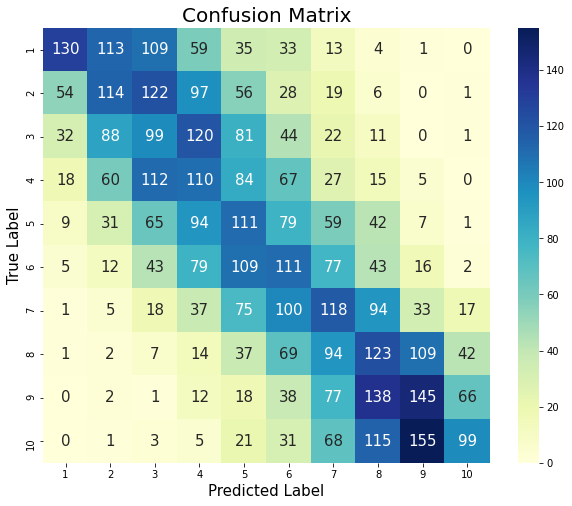

Precise accuracy: 0.23311897106109325
Adjacent accuracy: 0.5964630225080386
2-steps adjacent accuracy: 0.8181270096463023


In [33]:
print('LogisticAT model:')
confu_matrix(y_hat_mord_AT)

Logistic Regression model:


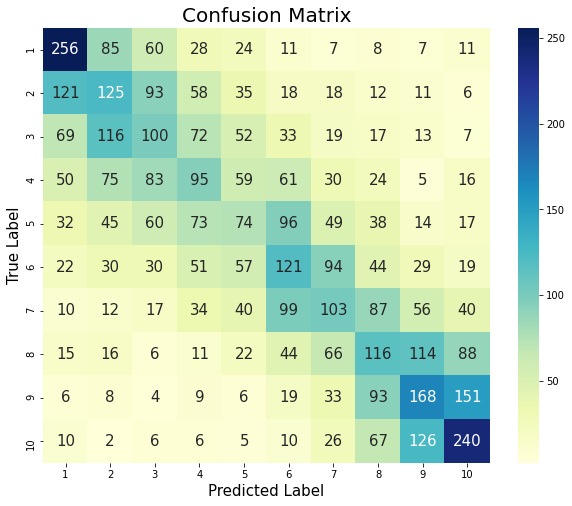

Precise accuracy: 0.2809485530546624
Adjacent accuracy: 0.6195739549839229
2-steps adjacent accuracy: 0.8018488745980707


In [34]:
print('Logistic Regression model:')
confu_matrix(y_hat_log)

Look at the confusion matrices of these two, we can clearly see that LogisticAT did a much better job, even though the `Precise accuracy` and `Adjacent accuracy` are a little bit lower. The matches fall nicely along the diagonal and we can clearly see the concentration there.  

Evenmore, if we look at the other two corners, where the true and predicted values lie at the extreme opposite, LogisticAT did a much better job and made very few mistakes there while normal Logistic Regression result in these areas are quite all over the place.  

One more observation is that Logistic Regression did a very good job predicting 1 and 10 classes, probably explains why it's accuracies is that high.

With LogisticAT as the winner, we can run a grid search to find the optimal alpha, its hyperparameter.  
Unfortunately, the only score metric we have to evaluate between different hyperparameters here is the default score metric, which is `Precise_accuracy` in our context.

In [35]:
#Set the base estimator
estimators = [('model', LogisticAT())] 
#instantiate the pipeline
pipe = Pipeline(estimators)
#Set up param grid, for LogisticAT, there is only one hyper parameter for us to tune: alpha
param_grid = [
            {'model': [LogisticAT()],
             'model__alpha': [10**i for i in range(-3,3)]} #set the list of alpha to run a grid search
]

grid = GridSearchCV(pipe, param_grid, 
                    cv=3) #Using 3 folds cross validation

#fit the grid search
fittedgrid = grid.fit(X_train_tran_df, y_train)

Then we can call the best_estimator_ attribute to get the best alpha

In [36]:
fittedgrid.best_estimator_

Pipeline(memory=None,
         steps=[('model', LogisticAT(alpha=10, max_iter=1000, verbose=0))],
         verbose=False)

Surprisingly, the best alpha is the default value. We dont have to run the model again.  
So let's print the result again as a checkpoint before we move on to Neural Network to see if we can improve it.

LogisticAT model is our best model so far:


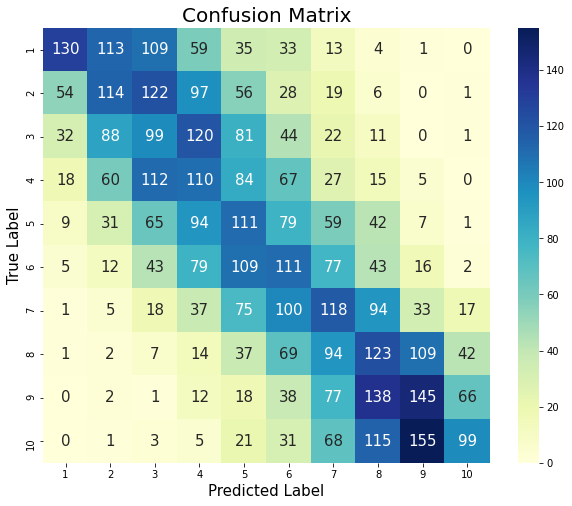

Precise accuracy: 0.23311897106109325
Adjacent accuracy: 0.5964630225080386
2-steps adjacent accuracy: 0.8181270096463023


In [37]:
print('LogisticAT model is our best model so far:')
confu_matrix(y_hat_mord_AT)

In [38]:
#export a joblib file for use later in our demo
joblib.dump(my_mord_AT, '/content/drive/MyDrive/Colab Notebooks/result/logAT.joblib')

['/content/drive/MyDrive/Colab Notebooks/result/logAT.joblib']

### 3.4 Modelling with Neural Network


After some research, I decided to try with regression Neural Network (similar with linear regression above) as the method is simple, straight forward and not too computational heavy.  

An unfortunately, we dont have a similar NN for mord yet (or I haven't found it yet).

Let's build a bsaeline feedforward Neural network and test it out:

In [39]:
# Declare the model
model = keras.Sequential()

#Declare hidden layers, here we chose 3 layers
#Note that we dont need to declare input layer in keras
model.add(layers.Dense(8192, activation = 'relu')) #We have around 9k columns, so the I want to set a close number for first layer 
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1024, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dropout(0.2))

#Declare output layer
model.add(layers.Dense(1)) #1 output layer with no activation, so the network will treat it as a linear regression

#Compile model
model.compile(
    #optimizer using SGD
    optimizer = keras.optimizers.SGD(learning_rate=0.01), #learning rate to determine how fast the model learn
    #loss
    loss = 'MSE', #Chose Mean Squared Error as loss function
    #Evaluate
    metrics = 'MSE' #Also chose Mean Squared Error as evaluation metrics
    )

#Set up early stopping, when the model no longer able to reduce loss, it will be stopped early to prevent overfitting
early_stopping = EarlyStopping(monitor='loss', 
                               patience=3) #Wait for 3 epochs to check loss
# train model
history = model.fit(X_train_tran_df,
                    y_train, 
                    validation_split=0.3, #split ratio for cross validation
                    epochs = 100,  #maximum epochs, most of the time the model will be stopped earlier
                    batch_size = 25, #set batch size of 25 samples each to propagated through the network
                    verbose = 1, #show info of each epoch
                    callbacks=early_stopping) #use early stopping set up above



# Get values for predicted rating
y_hat = model.predict(X_test_tran_df)
# Similar to linear regression, we need to do some transformation to get back our classes.
# Also need to squeeze y_hat back to 1 dimension
y_hat = y_hat.round().squeeze()
# Convert extreme value into their respective min,max
y_hat = np.where(y_hat >10,10,y_hat)
y_hat = np.where(y_hat <1,1,y_hat)

Epoch 1/100
558/558 [==============================] - 5s 9ms/step - loss: 9.5897 - MSE: 9.5897 - val_loss: 11.3355 - val_MSE: 11.3355
Epoch 2/100
558/558 [==============================] - 4s 8ms/step - loss: 5.1723 - MSE: 5.1723 - val_loss: 4.6155 - val_MSE: 4.6155
Epoch 3/100
558/558 [==============================] - 4s 8ms/step - loss: 4.2118 - MSE: 4.2118 - val_loss: 4.1629 - val_MSE: 4.1629
Epoch 4/100
558/558 [==============================] - 4s 8ms/step - loss: 3.9049 - MSE: 3.9049 - val_loss: 4.3183 - val_MSE: 4.3183
Epoch 5/100
558/558 [==============================] - 4s 8ms/step - loss: 3.5130 - MSE: 3.5130 - val_loss: 3.6484 - val_MSE: 3.6484
Epoch 6/100
558/558 [==============================] - 4s 8ms/step - loss: 3.2555 - MSE: 3.2555 - val_loss: 4.2412 - val_MSE: 4.2412
Epoch 7/100
558/558 [==============================] - 4s 8ms/step - loss: 3.0313 - MSE: 3.0313 - val_loss: 5.4171 - val_MSE: 5.4171
Epoch 8/100
558/558 [==============================] - 4s 8ms/step 

Let's check out the result:

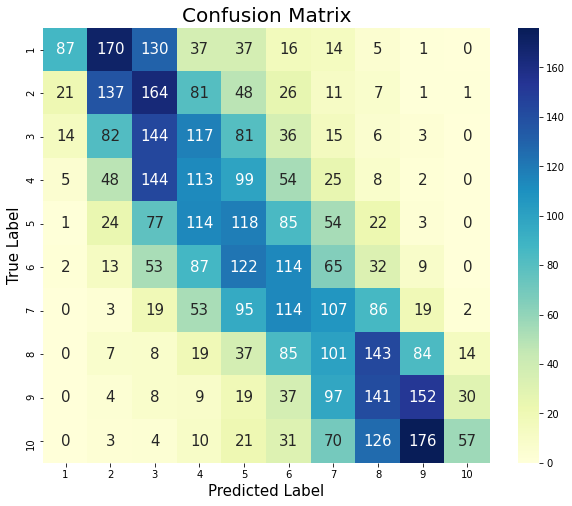

Precise accuracy: 0.23553054662379422
Adjacent accuracy: 0.6203778135048231
2-steps adjacent accuracy: 0.8402331189710611


In [40]:
confu_matrix(y_hat)

That's is impressive for the first try, the confusion matrix has a nice concentration that can comptete with LogiticAT.  And the accuracy is really good too.

From here, we can try to optimize to see if we can do better by define a new function to plug many hyperparameter and run them one by one.


In [41]:
def neural_model(para_list):
    '''
    Run and plot the confusion matrix for neural network with parameters as input
    The input (para_list) should have the following elements:
    para_list[0]:X_train
    para_list[0]:y_train
    para_list[0]:optimizer (including leanring rate)
    para_list[0]:losses
    para_list[0]:metrics
    para_list[0]:epoch
    para_list[0]:verbose
    '''
    # Declare the model
    model = keras.Sequential()

    #Declare hiddne layer
    model.add(layers.Dense(8192, activation = 'relu')) #We have around 9k columns, so the I want to set a close number for first layer 
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1024, activation = 'relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(16, activation = 'relu'))
    model.add(layers.Dropout(0.2))

    #Declare output layer
    model.add(layers.Dense(1)) #1 output layer with no activation

    #Compile model
    model.compile(
      #optimizer
      optimizer = para_list[2],
      #loss
      loss = para_list[3],
      #Evaluate
      metrics = para_list[4]
      )

    # train model
    early_stopping = EarlyStopping(monitor='loss', patience=3)
    history = model.fit(para_list[0],
                      para_list[1], 
                      validation_split=0.3, 
                      epochs = para_list[5], 
                      batch_size = 25, 
                      verbose = para_list[6], 
                      callbacks=early_stopping)


    # Evaluate 
    test_acc = model.evaluate(X_test_tran_df, y_test)
    print(test_acc)

    # Get values for predicted rating
    y_hat = model.predict(X_test_tran_df)
    # Squeeze y_hat back to 1 dimension
    y_hat = y_hat.round().squeeze()
    # Convert extreme value into their respective min,max
    y_hat = np.where(y_hat >10,10,y_hat)
    y_hat = np.where(y_hat <1,1,y_hat)

    #plot confusion matrix
    cf_matrix = confusion_matrix(y_test, y_hat)
    cf_matrix = pd.DataFrame(cf_matrix, columns = range(1,11), index = range(1,11))
    plt.figure(figsize=(10,8)) #Set figure size
    sns.heatmap(cf_matrix, #choose data for the heatmap
              cmap = 'YlGnBu', #set color map
              annot = True, #showing value inside the square
              fmt = '.0f', #format value to show whole number with no decimal point
              annot_kws={"fontsize":15}) #set font size for our values
    plt.title('Confusion Matrix',size = 20)
    plt.xlabel("Predicted Label", size = 15)
    plt.ylabel("True Label", size = 15) #naming our plot
    plt.show()

    count_0 = np.where(y_hat - y_test ==0, 1,0)
    count_1 = np.where(abs(y_hat-y_test)<=1,1,0)
    count_2 = np.where(abs(y_hat-y_test)<=2,1,0)
    acc_0 = count_0.sum()/len(count_0)
    acc_1 = count_1.sum()/len(count_1)
    acc_2 = count_2.sum()/len(count_2)
    print(f'Precise accuracy: {acc_0}')
    print(f'Adjacent accuracy: {acc_1}')
    print(f'2-steps adjacent accuracy: {acc_2}')

    return acc_0, acc_1, acc_2 #return accuracies so we can map them to summary table


As we dont have a pipeline library for neural network yet, we will have to create a new list of parameters and plug them into our nn function. Then we can put their accuracies into a summary table to compare

In [42]:
#create 12 combinations of hyper parameters to test
para1 = [X_train_tran_df, y_train, keras.optimizers.SGD(learning_rate=0.01), 'MSE', 'MSE', 50, 0]
para2 = [X_train_tran_df, y_train, keras.optimizers.SGD(learning_rate=0.02), 'MSE', 'MSE', 50, 0]
para3 = [X_train_tran_df, y_train, keras.optimizers.SGD(learning_rate=0.03), 'MSE', 'MSE', 50, 0]
para4 = [X_train_tran_df, y_train, keras.optimizers.Adam(learning_rate=0.001), 'MSE', 'MSE', 50, 0]
para5 = [X_train_tran_df, y_train, keras.optimizers.Adam(learning_rate=0.02), 'MSE', 'MSE', 50, 0]
para6 = [X_train_tran_df, y_train, keras.optimizers.Adam(learning_rate=0.03), 'MSE', 'MSE', 50, 0]
para7 = [X_train_tran_df, y_train, keras.optimizers.SGD(learning_rate=0.001), 'MAE', 'MAE', 50, 0]
para8 = [X_train_tran_df, y_train, keras.optimizers.SGD(learning_rate=0.02), 'MAE', 'MAE', 50, 0]
para9 = [X_train_tran_df, y_train, keras.optimizers.SGD(learning_rate=0.03), 'MAE', 'MAE', 50, 0]
para10 = [X_train_tran_df, y_train, keras.optimizers.Adam(learning_rate=0.001), 'MAE', 'MAE', 50, 0]
para11 = [X_train_tran_df, y_train, keras.optimizers.Adam(learning_rate=0.02), 'MAE', 'MAE', 50, 0]
para12 = [X_train_tran_df, y_train, keras.optimizers.Adam(learning_rate=0.03), 'MAE', 'MAE', 50, 0]


Score for para 1 is:
156/156 [==============================] - 1s 3ms/step - loss: 3.5516 - MSE: 3.5516
[3.5516011714935303, 3.5516011714935303]


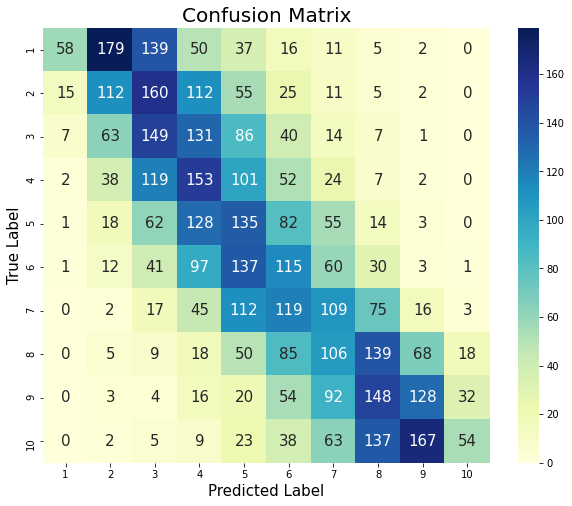

Precise accuracy: 0.2315112540192926
Adjacent accuracy: 0.6113344051446945
2-steps adjacent accuracy: 0.840032154340836
Score for para 2 is:
156/156 [==============================] - 1s 3ms/step - loss: 3.5624 - MSE: 3.5624
[3.562441825866699, 3.562441825866699]


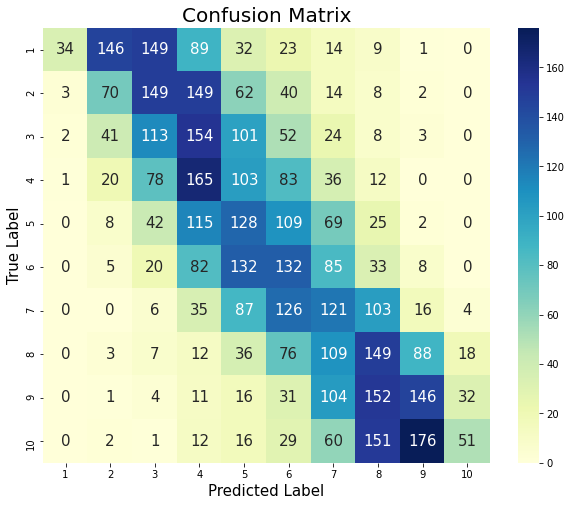

Precise accuracy: 0.22286977491961416
Adjacent accuracy: 0.604903536977492
2-steps adjacent accuracy: 0.842443729903537
Score for para 3 is:
156/156 [==============================] - 1s 3ms/step - loss: 3.6517 - MSE: 3.6517
[3.651726245880127, 3.651726245880127]


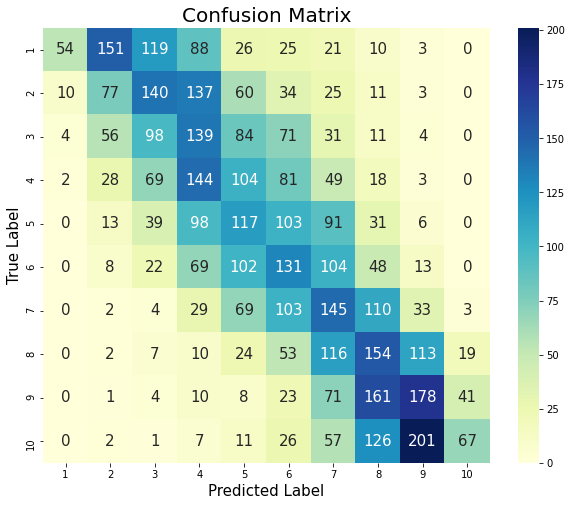

Precise accuracy: 0.23412379421221866
Adjacent accuracy: 0.6201768488745981
2-steps adjacent accuracy: 0.8354099678456591
Score for para 4 is:
156/156 [==============================] - 1s 3ms/step - loss: 4.1300 - MSE: 4.1300
[4.130012035369873, 4.130012035369873]


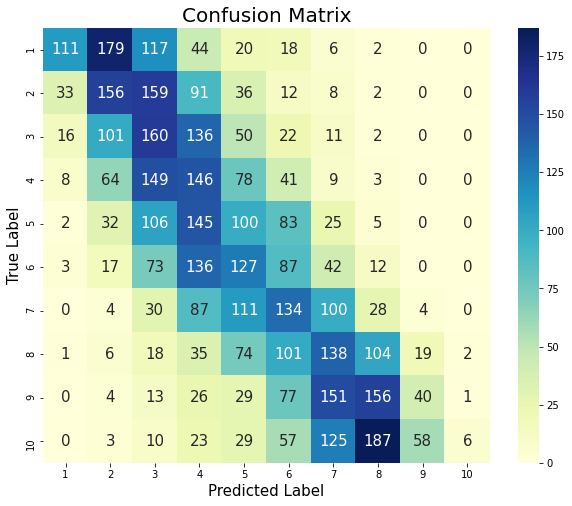

Precise accuracy: 0.2029742765273312
Adjacent accuracy: 0.5578778135048231
2-steps adjacent accuracy: 0.8018488745980707
Score for para 5 is:
156/156 [==============================] - 1s 3ms/step - loss: 3.8598 - MSE: 3.8598
[3.8598499298095703, 3.8598499298095703]


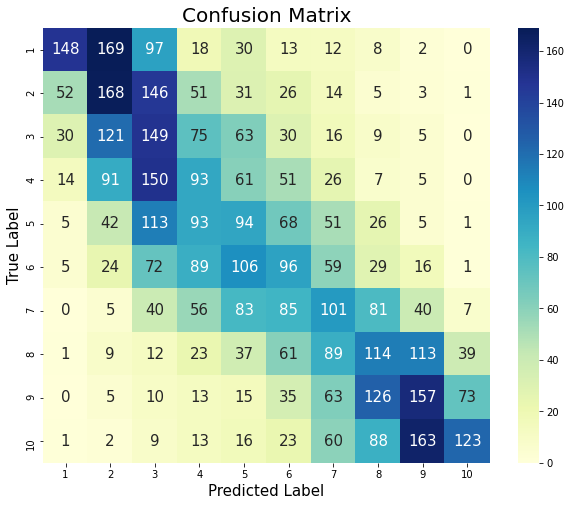

Precise accuracy: 0.2497990353697749
Adjacent accuracy: 0.617564308681672
2-steps adjacent accuracy: 0.8263665594855305
Score for para 6 is:
156/156 [==============================] - 1s 3ms/step - loss: 3.5837 - MSE: 3.5837
[3.583721876144409, 3.583721876144409]


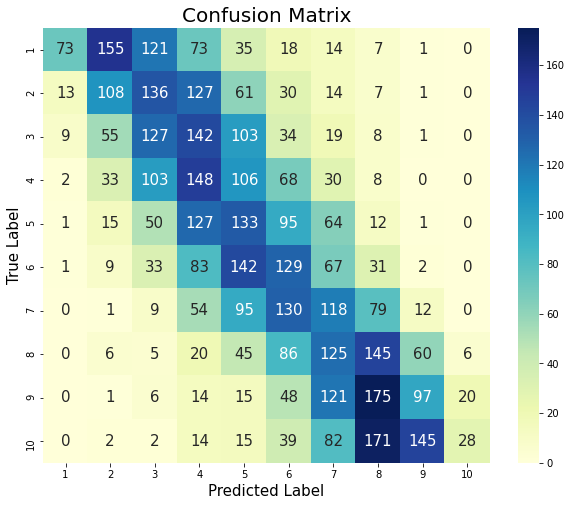

Precise accuracy: 0.2222668810289389
Adjacent accuracy: 0.5990755627009646
2-steps adjacent accuracy: 0.8362138263665595
Score for para 7 is:
156/156 [==============================] - 1s 3ms/step - loss: 3.8426 - MSE: 3.8426
[3.8425686359405518, 3.8425686359405518]


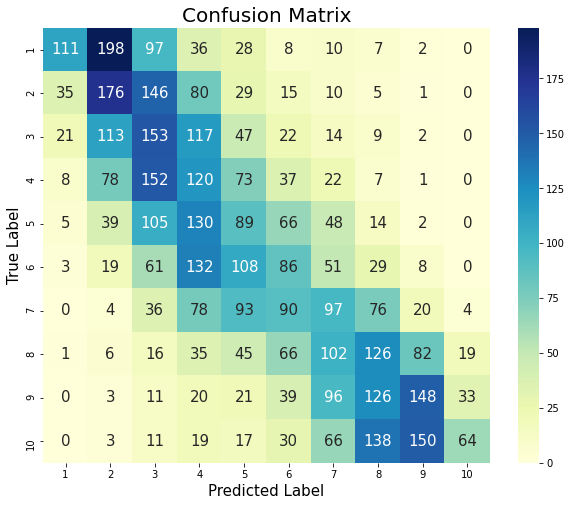

Precise accuracy: 0.23512861736334406
Adjacent accuracy: 0.6065112540192926
2-steps adjacent accuracy: 0.8287781350482315
Score for para 8 is:
156/156 [==============================] - 1s 4ms/step - loss: 3.7268 - MSE: 3.7268
[3.7268333435058594, 3.7268333435058594]


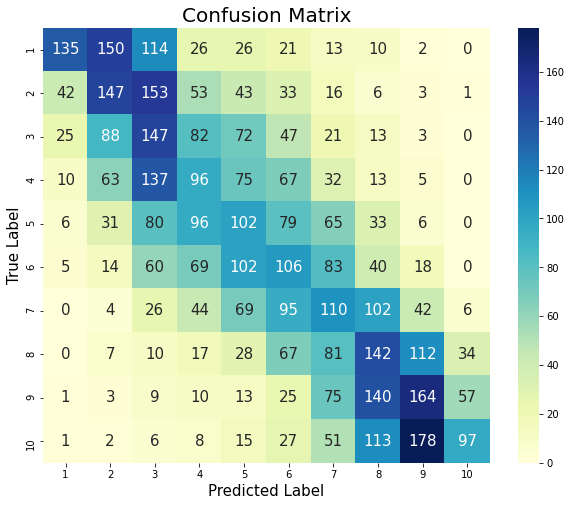

Precise accuracy: 0.2504019292604502
Adjacent accuracy: 0.622588424437299
2-steps adjacent accuracy: 0.8331993569131833
Score for para 9 is:
156/156 [==============================] - 1s 3ms/step - loss: 3.6973 - MSE: 3.6973
[3.6973414421081543, 3.6973414421081543]


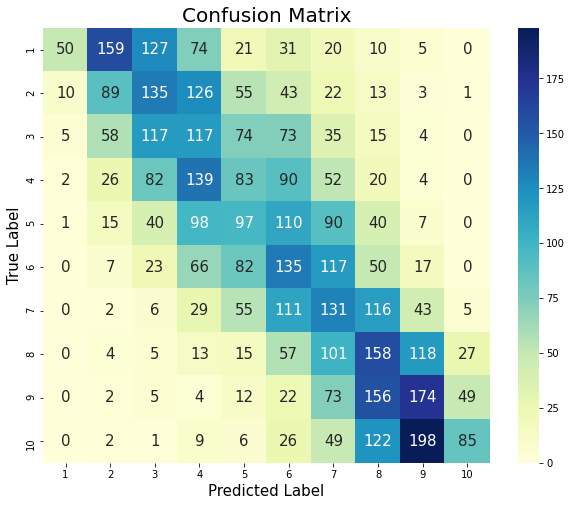

Precise accuracy: 0.23613344051446947
Adjacent accuracy: 0.6179662379421221
2-steps adjacent accuracy: 0.8331993569131833
Score for para 10 is:
156/156 [==============================] - 1s 3ms/step - loss: 4.2249 - MSE: 4.2249
[4.224854469299316, 4.224854469299316]


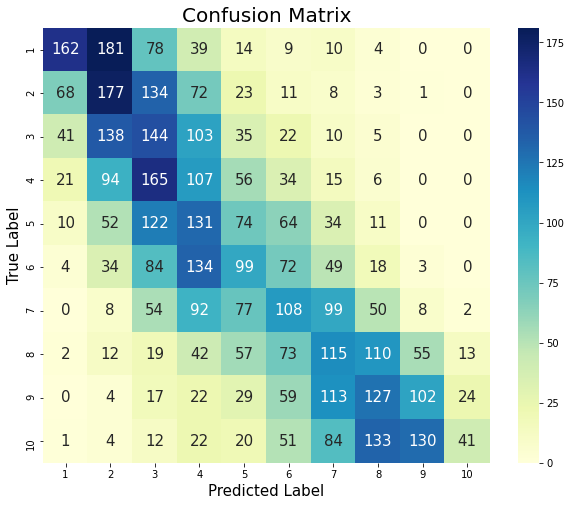

Precise accuracy: 0.21864951768488747
Adjacent accuracy: 0.5797829581993569
2-steps adjacent accuracy: 0.7966237942122186
Score for para 11 is:
156/156 [==============================] - 1s 3ms/step - loss: 3.6024 - MSE: 3.6024
[3.602431535720825, 3.602431535720825]


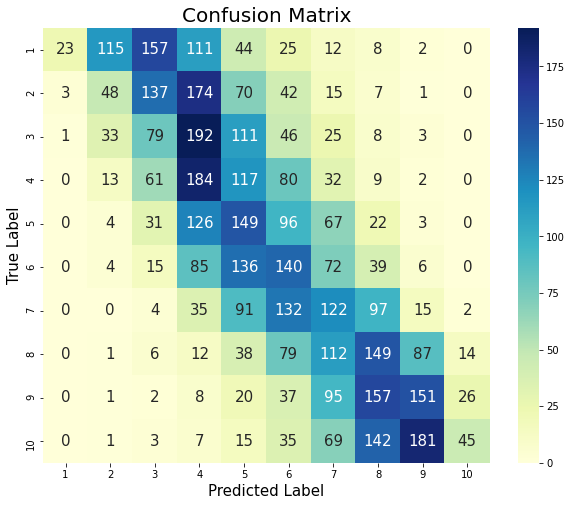

Precise accuracy: 0.21905144694533762
Adjacent accuracy: 0.5968649517684887
2-steps adjacent accuracy: 0.8368167202572347
Score for para 12 is:
156/156 [==============================] - 1s 3ms/step - loss: 3.7780 - MSE: 3.7780
[3.7780039310455322, 3.7780039310455322]


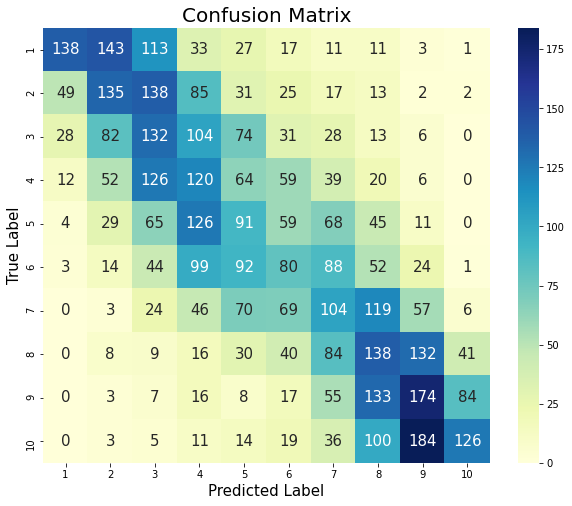

Precise accuracy: 0.24879421221864953
Adjacent accuracy: 0.6258038585209004
2-steps adjacent accuracy: 0.8384244372990354


In [43]:
#Map the para list into a final_list
final_list = [para1, para2, para3, para4, para5, para6, para7, para8, para9, para10, para11, para12]
#Run a loop to try all combinations
for i in range(len(final_list)):
  print(f'Score for para {i+1} is:')
  acc_0, acc_1, acc_2 = neural_model(final_list[0])
  #append the accuracy
  final_list[i].append(acc_0)
  final_list[i].append(acc_1)
  final_list[i].append(acc_2) 


Then we can create a summary table to see what is the optimal hyperparameters of out neural network.

In [44]:
nn_summary = pd.DataFrame(data = [para1[-3:], #Create new dataframe with only last 3 elements which is our accuracies
                            para2[-3:],
                            para3[-3:],
                            para4[-3:],
                            para5[-3:],
                            para6[-3:],
                            para7[-3:],
                            para8[-3:],
                            para9[-3:],
                            para10[-3:],
                            para11[-3:],
                            para12[-3:]], columns = ['Exact', 'adjacent', '2-steps adjacent']) #set columns name
nn_summary.sort_values('2-steps adjacent', ascending = False) #sort values to find the best model base on 

,Exact,adjacent,2-steps adjacent
1,0.222870,0.604904,0.842444
0,0.231511,0.611334,0.840032
11,0.248794,0.625804,0.838424
10,0.219051,0.596865,0.836817
5,0.222267,0.599076,0.836214
2,0.234124,0.620177,0.835410
7,0.250402,0.622588,0.833199
8,0.236133,0.617966,0.833199
6,0.235129,0.606511,0.828778
4,0.249799,0.617564,0.826367


We can see that para_2 has the highest 2-steps adjacent accuracy, the confusion matrix is similar but all the accuracies improved a little but compare with LogisticAT. So, Neural network with para_2 will be our model of choice.

### 3.5. Conclusion and future plan

After try out many different models, so far Regression Neural network is a clear winner (but not by much).

However, there are many advanced techniques that involved NPL that can push the accuracies much further, like using RNN or CNN in NLP. In the future, I would like to explore them further. A research paper I found mentioned that they can reach about 80% for adjacent accuracy for a 5 ordinal classes, I will try to apply them.

For the streamlit app, when I tried to export the neural network model into a h5 file, the file size jump to 300mb. So for the sake of the demo, I will use the joblib file from LogisticAT model.

That would be the end of my project as it is today. Please refer to readme.txt file and the final report for more information.

Thank you!!! 